In [1]:
import os 
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns

from data_provider.data_factory import data_provider
%reload_ext autoreload
%autoreload 2

In [2]:
lt_logs_df = pd.read_csv('./logs/calmip_logs.csv', index_col = 0)
from types import SimpleNamespace
usc_args = SimpleNamespace(**lt_logs_df.loc[471].to_dict())
usc_args.batch_size = 25

usc_args.input_features = 'A'
usc_args.use_offense = False
usc_args.features = 'MS'
usc_args.consider_only_offense = True

usc_args.root_path = "./dataset/USC/"
usc_args.checkpoints = "./checkpoints/"
usc_args.results_path = "./results/"

### x_mark

In [3]:
th = 24
usc_args.seq_len , usc_args.pred_len, usc_args.label_len = th,th, th//4
train_ds, train_dl = data_provider(args= usc_args, flag = 'train')
test_ds, test_dl = data_provider(args= usc_args, flag = 'test')

### Progress

(89210, 24, 63) (89210, 24, 63)


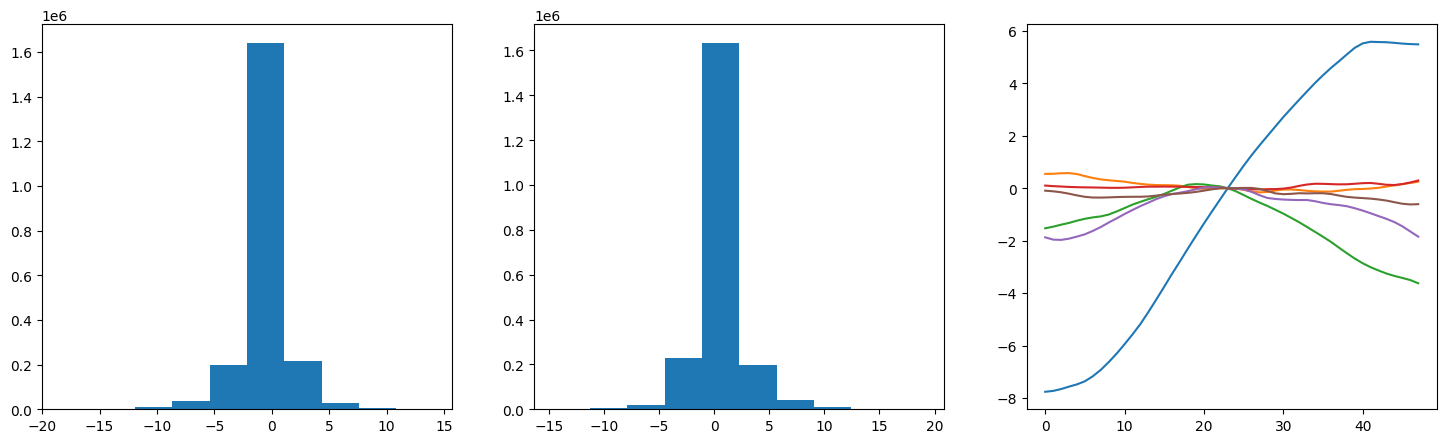

In [4]:
th = 24
Xs = np.load(f'./dataset/USC/seq{th}_pred{th}_X.npy')
Ys = np.load(f'./dataset/USC/seq{th}_pred{th}_Y.npy')
print(Xs.shape, Ys.shape)

fig, axs = plt.subplots(1,3,figsize = (18,5));
axs[0].hist(Xs[:,:,1].reshape(-1));
axs[1].hist(Ys[:,:,1].reshape(-1));
for i in range(6):
    ind = np.random.randint(Xs.shape[0])
    axs[2].plot(np.concatenate((Xs[ind,:,1], Ys[ind,:,1])))

(62446, 24, 61) (62446, 24, 61) (13382, 24, 61) (13382, 24, 61)


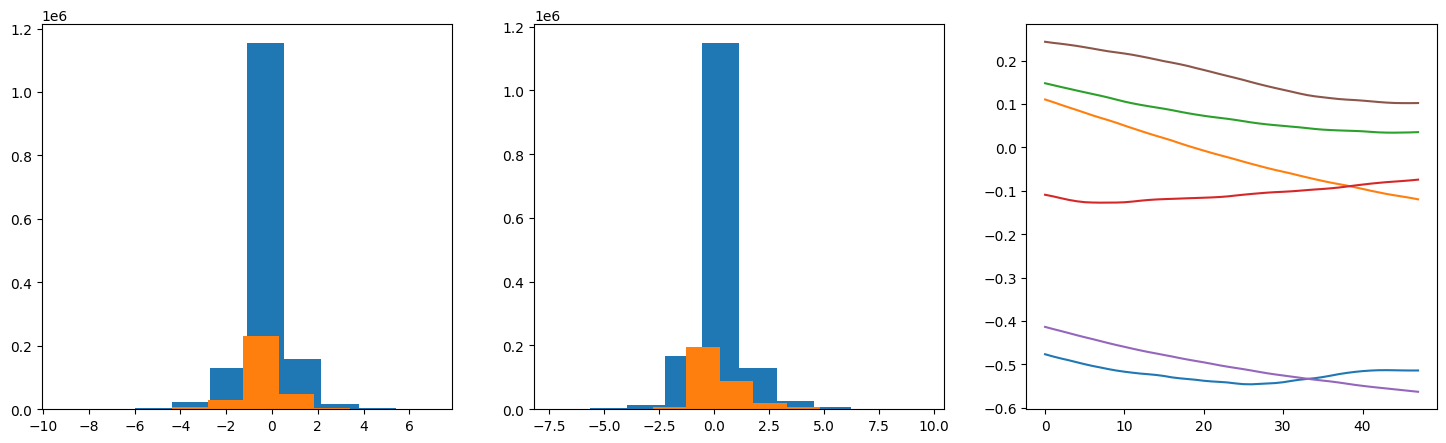

In [5]:
usc_args.seq_len , usc_args.pred_len = th,th
train_ds, train_dl = data_provider(args= usc_args, flag = 'train')
test_ds, test_dl = data_provider(args= usc_args, flag = 'test')
print(train_ds.data_x.shape, train_ds.data_y.shape, test_ds.data_x.shape, test_ds.data_y.shape)
fig, axs = plt.subplots(1,3,figsize = (18,5));
axs[0].hist(train_ds.data_x[:,:,-1].reshape(-1));
axs[0].hist(test_ds.data_x[:,:,-1].reshape(-1));
axs[1].hist(train_ds.data_y[:,:,-1].reshape(-1));
axs[1].hist(test_ds.data_y[:,:,-1].reshape(-1));
for i in range(3):
    train_ind, test_ind = np.random.randint(train_ds.__len__()), np.random.randint(test_ds.__len__())
    axs[2].plot(np.concatenate((train_ds.data_x[train_ind,:,0], train_ds.data_y[train_ind,:,0])))
    axs[2].plot(np.concatenate((test_ds.data_x[test_ind,:,0], test_ds.data_y[test_ind,:,0])))

### Inverse transform

In [6]:
ind = 0

unscaled_X = Xs[ind,:,1]
unscaled_Y = Ys[ind,:,1]
print(f"{unscaled_X.shape=}, {unscaled_Y.shape=}")
scaled_X = train_ds.data_x[ind,:,-1]
scaled_Y = train_ds.data_y[ind,:,-1]
print(f"{scaled_X.shape=}, {scaled_Y.shape=}")

rescaled_X = (unscaled_X - train_ds.scaler['mean'][-1]) / train_ds.scaler['scale'][-1]
rescaled_Y = (unscaled_Y - train_ds.scaler['mean'][-1]) / train_ds.scaler['scale'][-1]
print(f"{rescaled_X.shape=}, {rescaled_Y.shape=}")

print(f"Test scaling operation : {np.allclose(scaled_X, rescaled_X) and np.allclose(scaled_Y, rescaled_Y)}")

unscaled_X.shape=(24,), unscaled_Y.shape=(24,)
scaled_X.shape=(24,), scaled_Y.shape=(24,)
rescaled_X.shape=(24,), rescaled_Y.shape=(24,)
Test scaling operation : True


In [7]:
ind = 2

unscaled_X = Xs[-ind,:,1]
unscaled_Y = Ys[-ind,:,1]
print(f"{unscaled_X.shape=}, {unscaled_Y.shape=}")
scaled_X = test_ds.data_x[-ind,:,-1]
scaled_Y = test_ds.data_y[-ind,:,-1]
print(f"{scaled_X.shape=}, {scaled_Y.shape=}")

rescaled_X = (unscaled_X - test_ds.scaler['mean'][-1]) / test_ds.scaler['scale'][-1]
rescaled_Y = (unscaled_Y - test_ds.scaler['mean'][-1]) / test_ds.scaler['scale'][-1]
print(f"{rescaled_X.shape=}, {rescaled_Y.shape=}")

print(f"Test scaling operation : {np.allclose(scaled_X, rescaled_X) and np.allclose(scaled_Y, rescaled_Y)}")

unscaled_X.shape=(24,), unscaled_Y.shape=(24,)
scaled_X.shape=(24,), scaled_Y.shape=(24,)
rescaled_X.shape=(24,), rescaled_Y.shape=(24,)
Test scaling operation : True


### Angles

In [8]:
df = pd.read_csv('../Collective_behavior/preproc_data/USC/all_games_positions.csv',index_col = 0)
df

,frame,player_id,x,y,action,half,offense,player,v_x,v_y,v,uv_x,uv_y,goal_angle,target,act_progression,game_id,action_id
0,2023-08-25 19:31:27.400,JEAN THOMAS,22.233002,55.553402,1,1,True,4,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
1,2023-08-25 19:31:27.400,JACK WHETTON,22.483604,30.255229,1,1,True,5,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
2,2023-08-25 19:31:27.400,GUILLAUME TARTAS,23.177224,53.527926,1,1,True,1,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
3,2023-08-25 19:31:27.400,DORIAN LABORDE,27.876374,51.659946,1,1,True,12,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
4,2023-08-25 19:31:27.400,FABIEN PERRIN,25.649343,34.601532,1,1,True,13,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188920,2025-03-07 20:57:24.100,BRETT HERRON,43.731861,37.777256,102,2,False,10,-0.403193,-0.092362,0.413636,-0.974751,-0.223292,-167.097511,58.473546,-0.754026,2425_23,41102
188921,2025-03-07 20:57:24.100,UGO PACOME,40.570186,18.138857,102,2,False,9,-0.895585,-0.447215,1.001037,-0.894658,-0.446752,-153.464500,58.473546,-0.754026,2425_23,41102
188922,2025-03-07 20:57:24.100,VINCENT PINTO,58.047428,29.359716,102,2,False,14,-1.398516,-0.497747,1.484453,-0.942109,-0.335307,-160.408795,58.473546,-0.754026,2425_23,41102
188923,2025-03-07 20:57:24.100,LOUIS DESCOUX,55.923958,28.504784,102,2,False,5,2.069783,-0.930800,2.269447,0.912021,-0.410144,-24.213872,58.473546,-0.754026,2425_23,41102


(array([671693., 668418., 847268., 635131., 858987., 795167., 670873.,
        866017., 654612., 659169.]),
 array([-1.79999803e+02, -1.43999829e+02, -1.07999856e+02, -7.19998823e+01,
        -3.59999089e+01,  6.45568576e-05,  3.60000380e+01,  7.20000114e+01,
         1.07999985e+02,  1.43999958e+02,  1.79999932e+02]),
 <BarContainer object of 10 artists>)

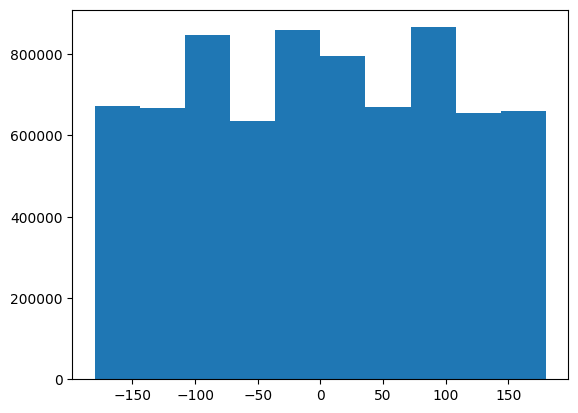

In [9]:
plt.hist(df['goal_angle'])

(51523, 64, 63) (51523, 64, 63)


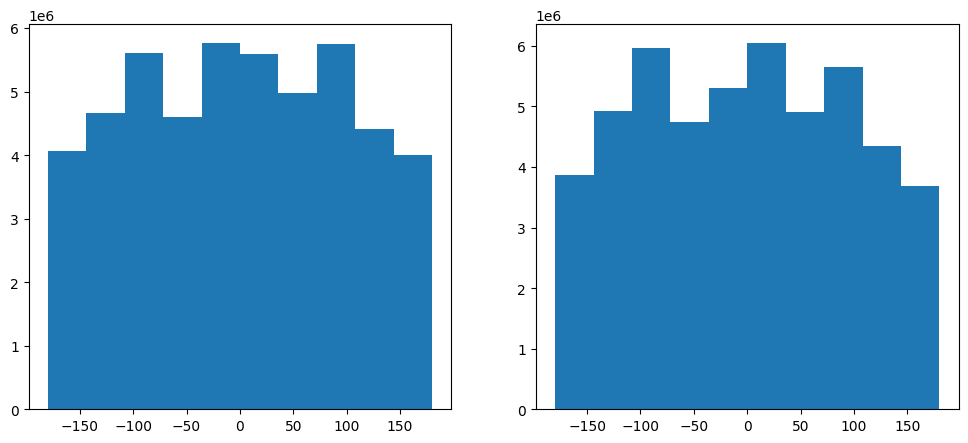

In [10]:
th = 64
Xs = np.load(f'./dataset/USC/seq{th}_pred{th}_X.npy')
Ys = np.load(f'./dataset/USC/seq{th}_pred{th}_Y.npy')
print(Xs.shape, Ys.shape)
angle_mask = [(i+2)%4 == 0 and i >2 for i in range(Xs.shape[2])]

fig, axs = plt.subplots(1,2,figsize = (12,5));
axs[0].hist(Xs[:,:,angle_mask].reshape(-1));
axs[1].hist(Ys[:,:,angle_mask].reshape(-1));


### Local logs

In [19]:
lldf = pd.read_csv('./logs/long_term_forecast.csv',index_col = 0)
hp_cols = ['model','features','enc_in','dec_in','c_out','seq_len','pred_len','learning_rate','dropout','optimizer','wd','e_layers','d_model','n_heads','d_layers','d_ff']
lldf[hp_cols+ ['rmse','fde']].tail()

,model,features,enc_in,dec_in,c_out,seq_len,pred_len,learning_rate,dropout,optimizer,wd,e_layers,d_model,n_heads,d_layers,d_ff,rmse,fde
366,LSTM,MS,61,61,61,24,24,0.001,0.1,adamw,0.05,1,32,4,1,64,1.500638,2.519662
367,iTransformer,MS,61,61,61,32,32,0.001,0.1,adamw,0.05,1,32,4,1,64,1.672787,3.004596
368,PatchTST,MS,61,61,61,32,32,0.001,0.1,adamw,0.05,1,32,4,1,64,1.732199,3.110906
369,TimesNet,MS,61,61,61,32,32,0.001,0.1,adamw,0.05,1,32,4,1,64,1.891930,3.248230
370,DLinear,MS,61,61,61,32,32,0.001,0.1,adamw,0.05,1,32,4,1,64,1.810980,3.242352


In [12]:
ett_args = SimpleNamespace(**lldf.loc[0].to_dict())
ett_ds, ett_dl = data_provider(ett_args, 'train')

In [13]:
seq_x, seq_y, seq_x_mark, seq_y_mark = ett_ds.__getitem__(0)
seq_x.shape, seq_y.shape, seq_x_mark.shape, seq_y_mark.shape

((96, 7), (144, 7), (96, 4), (144, 4))